In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars, 1)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

In [3]:
block_size = 3

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(4)
random.shuffle(words)

n1 = int(0.8*len(words)) #80% of words
n2 = int(0.9*len(words)) #90% of words

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182359, 3]) torch.Size([182359])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22994, 3]) torch.Size([22994])


In [4]:
# utility function used to compare manual gradients to PyTorch gradients

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')



In [5]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [7]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = (1/n)*(hprebn.sum(0, keepdim=True))
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss.item()

3.515425682067871

In [27]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = - 1 / n

cmp('dlogprob', dlogprobs, logprobs)

dlogprob        | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
logprobs.grad[range(n), Yb][0]

tensor(-0.0312)

In [43]:
dprobs = ( 1.0 / probs) * dlogprobs

cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [57]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# just multiplication derivative, with the propagate of the chain rule
# because during the multiplication the result is being summed across 1st dimension

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [55]:
(counts * dprobs).sum(1).shape, dcounts_sum_inv.shape

(torch.Size([32]), torch.Size([32, 1]))

In [75]:
dcounts = counts_sum_inv * dprobs # counts is used twice i.e in counts_sum_inv and count_sum
# `counts * counts_sum_inv` considering this
cmp('counts', dcounts, counts)

counts          | exact: False | approximate: False | maxdiff: 0.003768607974052429


In [74]:
dcounts_sum = (- counts_sum ** -2) * dcounts_sum_inv

cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [76]:
dcounts +=torch.ones_like(counts) * dcounts_sum
# `counts.sum(1, keepdims=True)` considering this
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [78]:
dnorms_logits = counts * dcounts
# norm_logits.exp()
cmp('norms_logits', dnorms_logits, norm_logits)

norms_logits    | exact: True  | approximate: True  | maxdiff: 0.0


In [71]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [88]:
dlogits = dnorms_logits.clone()
# `logits - logit_maxes` considering this
dlogit_maxes = (-dnorms_logits).sum(1, keepdim=True)

cmp('logits', dlogits, logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


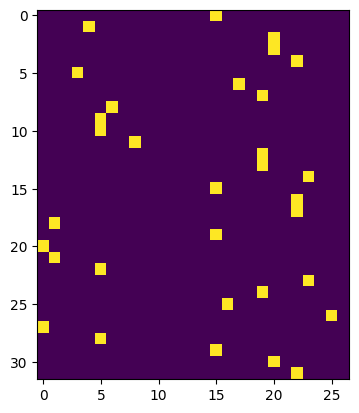

In [89]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [90]:
# considering `logits.max(1, keepdim=True).values`

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [92]:
cmp('logprob', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts', dcounts, counts)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norms_logits', dnorms_logits, norm_logits)
cmp('logits', dlogits, logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)

logprob         | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norms_logits    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


[Resume Here](https://youtu.be/q8SA3rM6ckI?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=2509)